**MAESTRÍA EN INTELIGENCIA ARTIFICIAL APLICADA**

**Curso: TC4029 - Ciencia y analítica de datos**

Tecnológico de Monterrey

Prof Grettel Barceló Alonso

**Semana 8**
Regresión Lineal

---

*   NOMBRE: ---------------------------------------------------------
*   MATRÍCULA: ----------------------------------------------------

In [292]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [293]:
import os
DIR = "/content/drive/MyDrive/Colab Notebooks/MNA/TC4029 - Ciencia y analítica de datos/Semana 8/Actividad8_RLineal"
os.chdir(DIR)

In [294]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [295]:
insurance_df = pd.read_csv('insurance.csv')
insurance_df

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


# **Parte 1**. EDA

Efectúa una exploración inicial de los datos a través de:

1a) Estadísticas descriptivas para todas las variables del dataframe.

In [296]:
display(insurance_df.describe())
insurance_df.select_dtypes(include=object).describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


,sex,smoker,region
count,1338,1338,1338
unique,2,2,4
top,male,no,southeast
freq,676,1064,364


1b) Búsqueda de valores faltantes.

In [297]:
insurance_df.isnull().mean()*100

,0
age,0.0
sex,0.0
bmi,0.0
children,0.0
smoker,0.0
region,0.0
charges,0.0


1c) Histrogramas y boxplots para las variables cuantitativas y diagramas de barras con la frecuencia para las variables categóricas.

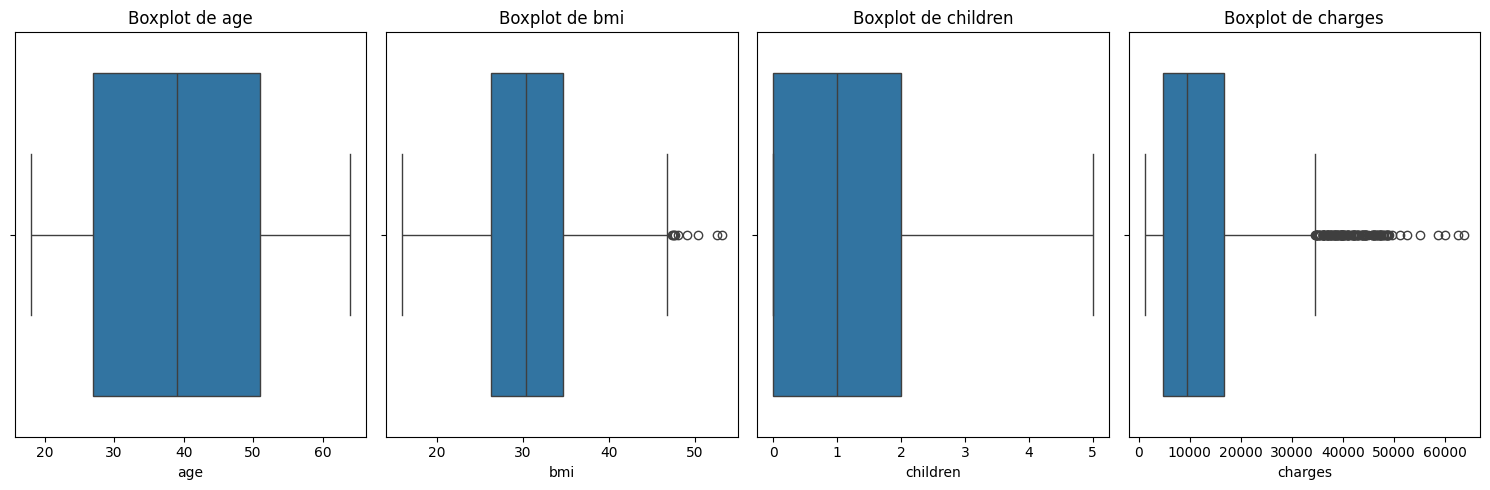

In [298]:
#Cuantitativos
columnas = insurance_df.select_dtypes(exclude=object).columns
plt.figure(figsize=(15, 5))
for i, col in enumerate(columnas, 1):
    plt.subplot(1, 4, i)
    sns.boxplot(x=insurance_df[col])
    plt.title(f"Boxplot de {col}")
    plt.xlabel(col)
plt.tight_layout()

In [299]:
insurance_df['sex'].index

RangeIndex(start=0, stop=1338, step=1)

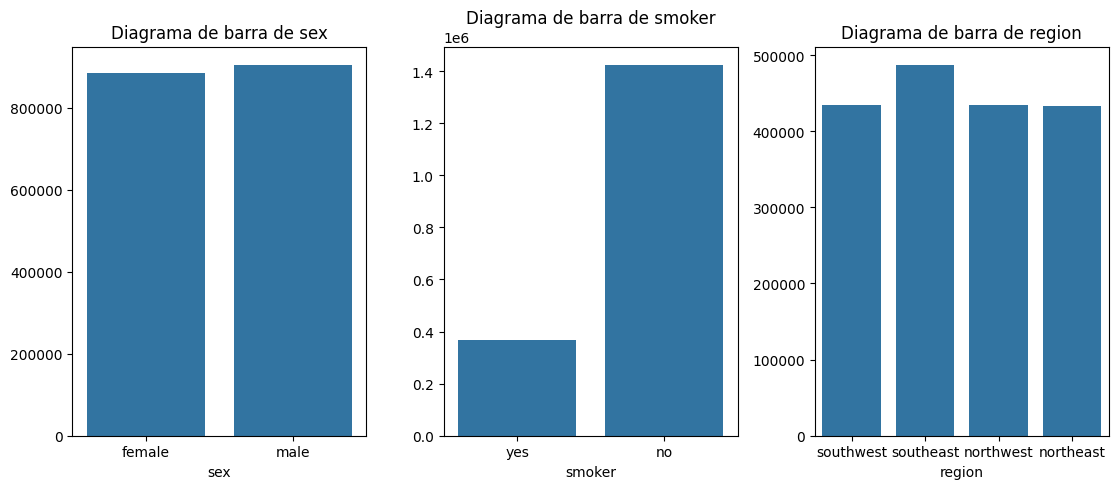

In [300]:
#Cualitativos
columnas = insurance_df.select_dtypes(include=object).columns
plt.figure(figsize=(15, 5))
for i, col in enumerate(columnas, 1):
    plt.subplot(1, 4, i)
    sns.barplot(insurance_df,x=insurance_df[col],y=insurance_df[col].count(), estimator="sum",errorbar=None)
    plt.title(f"Diagrama de barra de {col}")
    plt.xlabel(col)
plt.tight_layout()

Para responder los siguientes cuestionamientos, genera los gráficos indicados:

2a) ¿Hay diferencias significativas de las primas según el sexo? Compara la distribución de la variable `charges` por medio de un boxplot.

<Axes: xlabel='charges', ylabel='sex'>

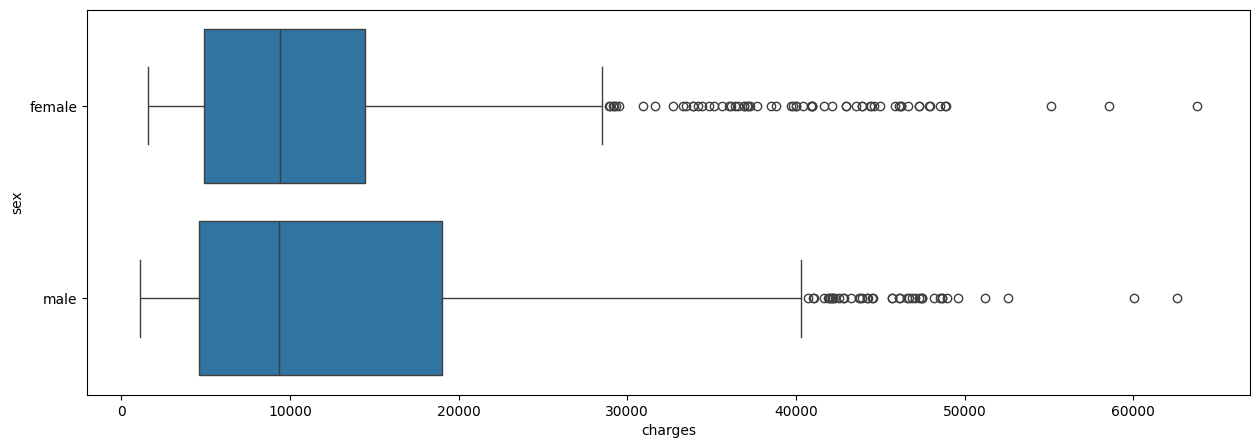

In [301]:
plt.figure(figsize=(15, 5))
sns.boxplot(insurance_df,x=insurance_df['charges'],y=insurance_df['sex'])

2b) Crea un diagrama de dispersión de `charges` versus el `bmi` que incorpore la distinción por las categorías `smoker` y `children` (tip: utiliza el parámetro `size`) ¿Hay alguna conclusión importante que se derive del gráfico?

<Axes: xlabel='bmi', ylabel='charges'>

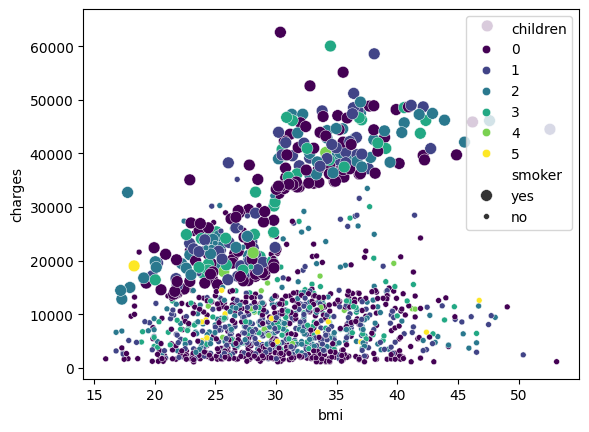

In [302]:
sns.scatterplot(insurance_df,y=insurance_df['charges'],x=insurance_df['bmi'],size=insurance_df['smoker'], hue='children',palette='viridis')


2c) Elabora un mapa de calor que muestre la correlación de las variables numéricas.

<Axes: >

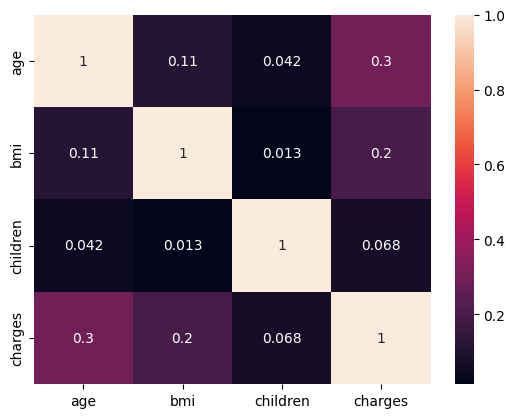

In [303]:
sns.heatmap(insurance_df.select_dtypes(exclude=object).corr(),annot=True)

Obtén un dataframe con las observaciones que tengan valores atípicos en `charges`.

3a) ¿Cuál es el promedio de `age` y de `bmi` en el dataframe de valores atípicos obtenido?

In [304]:
l = insurance_df['charges'].quantile(0.25)
h = insurance_df['charges'].quantile(0.75)
iqr = h - l
ll = l - 1.5*iqr
hl = h + 1.5*iqr

outliers = pd.DataFrame(insurance_df[(insurance_df['charges'] < ll) | (insurance_df['charges'] > hl)])
#insurance_df.drop(index=outliers.index, inplace=True)
print('Promedio edad:',insurance_df.age.mean(), 'y bmi:',insurance_df.bmi.mean())
display(insurance_df)

Promedio edad: 39.20702541106129 y bmi: 30.66339686098655


,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


3b) ¿Qué porcentaje de estas observaciones (en el dataframe de valores atípicos obtenidos) se corresponden a mujeres y a hombres? ¿A fumadores y no fumadores?

In [305]:
display(insurance_df.sex.value_counts()/insurance_df.shape[0]*100)
insurance_df.smoker.value_counts()/insurance_df.shape[0]*100

,count
sex,
male,50.523169
female,49.476831


,count
smoker,
no,79.521674
yes,20.478326


# **Parte 2**. Preprocesamiento

In [306]:
insurance_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


4. Separa las variables del dataframe: en `X` coloca los predictores y en `y` la variable de respuesta o salida (`charges`).

In [307]:
x = insurance_df.drop(columns='charges')
y = insurance_df.charges

In [308]:
x

,age,sex,bmi,children,smoker,region
0,19,female,27.900,0,yes,southwest
1,18,male,33.770,1,no,southeast
2,28,male,33.000,3,no,southeast
3,33,male,22.705,0,no,northwest
4,32,male,28.880,0,no,northwest
...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest
1334,18,female,31.920,0,no,northeast
1335,18,female,36.850,0,no,southeast
1336,21,female,25.800,0,no,southwest


5. Divide el conjunto en entrenamiento y prueba (80:20) considerando:


*   El parámetro `random_state` con el valor de 1 para garantizar reproducibilidad.
*   Analiza los diagramas de barras obtenidos en el ejercicio 1c. Con los resultados observados, es conveniente usar la variable `smoker` en la estrategia de estratificación.
*   Como ya tienes separadas en `X` e `y` los predictores y salida, consulta cómo ejecutar la función `train_test_split()` para obtener `Xtrain, Xtest, ytrain, ytest` en una única instrucción.

In [309]:
from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(x, y, test_size = 0.2, random_state=1,stratify=x['smoker'])

In [310]:
Xtrain

,age,sex,bmi,children,smoker,region
42,41,male,21.780,1,no,southeast
847,23,male,50.380,1,no,southeast
625,29,female,26.030,0,no,northwest
394,46,female,32.300,2,no,northeast
621,37,male,34.100,4,yes,southwest
...,...,...,...,...,...,...
56,58,female,31.825,2,no,northeast
599,52,female,37.525,2,no,northwest
36,62,female,32.965,3,no,northwest
1179,31,male,29.810,0,yes,southeast


6. Prepara un transformador, denominado `preprocessing`, para aplicar escalamiento *MinMax* a los predictores numéricos y codificación *one-hot* a los categóricas.

In [311]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler,StandardScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer, make_column_selector

num_pipeline = make_pipeline(SimpleImputer(strategy='median'), MinMaxScaler())
cat_pipeline = make_pipeline(SimpleImputer(strategy='most_frequent'), OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))

preprocessing = ColumnTransformer([
    ('num', num_pipeline, make_column_selector(dtype_include=np.number)),
    ('cat', cat_pipeline, make_column_selector(dtype_include=object))])

# **Parte 3**. Entrenando y evaluando el modelo de RL

7. Ejecuta un pipeline con el transformador creado y el algoritmo de regresión lineal para entrenar un modelo denominado `lr_model`.

Evalúa el modelo en el conjunto de prueba y obtén la raíz del error cuadrático medio (`RMSE`) y la métrica `R` cuadrado ($R^2$). Aunque ésta última la estudiarás a detalle la próxima semana, ahora sólo debes saber que toma valores entre 0 y 1, donde 1 indica un ajuste perfecto y, por tanto, un modelo muy fiable para las previsiones futuras. La función de scikit-learn que determina esta métrica es: [`r2_score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.r2_score.html)

In [312]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, root_mean_squared_error

lr_model = make_pipeline(preprocessing, LinearRegression())
lr_model.fit(Xtrain, ytrain)
predictions = lr_model.predict(Xtest)

print('The Root Mean Square Error (RMSE) is:', root_mean_squared_error(ytest, predictions))
print('The R square (R2) is:', r2_score(ytest, predictions))


The Root Mean Square Error (RMSE) is: 5698.759784532356
The R square (R2) is: 0.7538547215244324


**Valora el rendimiento del modelo con los siguientes cambios:**


8. Reemplaza los outliers de `charges` con el límite superior (`Q3 + 1.5 * IQR`). Haz el cambio en ambos conjuntos: `ytrain` y `ytest`, previo a la aplicación del mismo pipeline. Guarda el modelo como `lr_model2`.


In [313]:
hltr = ytrain.quantile(0.75) + 1.5*(ytrain.quantile(0.75)-ytrain.quantile(0.25))
hlt = ytest.quantile(0.75) + 1.5*(ytest.quantile(0.75)-ytest.quantile(0.25))
print(ll, hl)
ytrain[ytrain<ll] = ll
ytrain[ytrain>hl] = hl
ytest[ytest<ll] = ll
ytest[ytest>hl] = hl

lr_model2 = make_pipeline(preprocessing, LinearRegression())
lr_model2.fit(Xtrain, ytrain)
predictions = lr_model2.predict(Xtest)

print('The Root Mean Square Error (RMSE) is:', root_mean_squared_error(ytest, predictions))
print('The R square (R2) is:', r2_score(ytest, predictions))

-13109.1508975 34489.350562499996
The Root Mean Square Error (RMSE) is: 4812.06172831982
The R square (R2) is: 0.7637776364359082


9. Prepara otro transformador, denominado `preprocessing2`, para aplicar escalamiento estándar a los predictores numéricos y codificación ordinal a los categóricas. Aplícalo en un nuevo pipeline utilizando nuevamente regresión lineal. Guarda el modelo como `lr_model3`.

**Nota.** Los cambios se ejecutan de manera consecutiva, por ejemplo: el reemplazo de los outliers también se ejecuta previo al transformador `preprocessing2` y así sucesivamente.

In [314]:
num_pipeline2 = make_pipeline(SimpleImputer(strategy='median'), StandardScaler())
cat_pipeline2 = make_pipeline(SimpleImputer(strategy='most_frequent'), OrdinalEncoder())

preprocessing2 = ColumnTransformer([
    ('num', num_pipeline2, make_column_selector(dtype_include=np.number)),
    ('cat', cat_pipeline2, make_column_selector(dtype_include=object))])

lr_model3 = make_pipeline(preprocessing2, LinearRegression())
lr_model3.fit(Xtrain, ytrain)
predictions = lr_model3.predict(Xtest)

print('The Root Mean Square Error (RMSE) is:', root_mean_squared_error(ytest, predictions))
print('The R square (R2) is:', r2_score(ytest, predictions))

The Root Mean Square Error (RMSE) is: 4811.600670456455
The R square (R2) is: 0.7638229005936741


10. Utiliza regresión polinomial para verificar si se produce un mejor ajuste. Intenta con varios grados, aunque debes dejar en el código sólo el de mejor rendimiento. Guarda el modelo como `lr_model4`.

In [320]:
from sklearn.preprocessing import PolynomialFeatures

lr_model4 = make_pipeline(preprocessing2, PolynomialFeatures(degree=2, include_bias=False),LinearRegression())#LinearRegression()
lr_model4.fit(Xtrain, ytrain)
predictions = lr_model4.predict(Xtest)

print('The Root Mean Square Error (RMSE) is:', root_mean_squared_error(ytest, predictions))
print('The R square (R2) is:', r2_score(ytest, predictions))

The Root Mean Square Error (RMSE) is: 4285.5703109655615
The R square (R2) is: 0.8126404302016093
